In [1]:
"""Use Perona-Malik regularistion to deblur image"""

'Use Perona-Malik regularistion to deblur image'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.sparse as sp

from deblurring.blurring import blur_and_noise
from solvers.least_square import LSQRSolver
from common.operators import derivative_operator, dx_operator, dy_operator, identity_operator, perona_malik_operator
from evaluation.tuning import StandardTuner, IterativeTuner

Estimated noise variance 2.601876431897141e-05 vs. actual 2.5899715383858184e-05


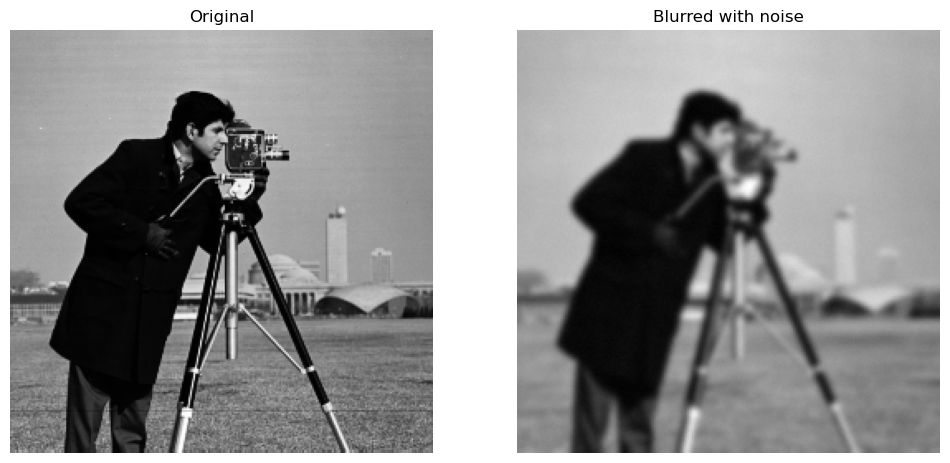

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../../data/Cameraman256.png")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02 * np.std(f)  # 2% noise
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

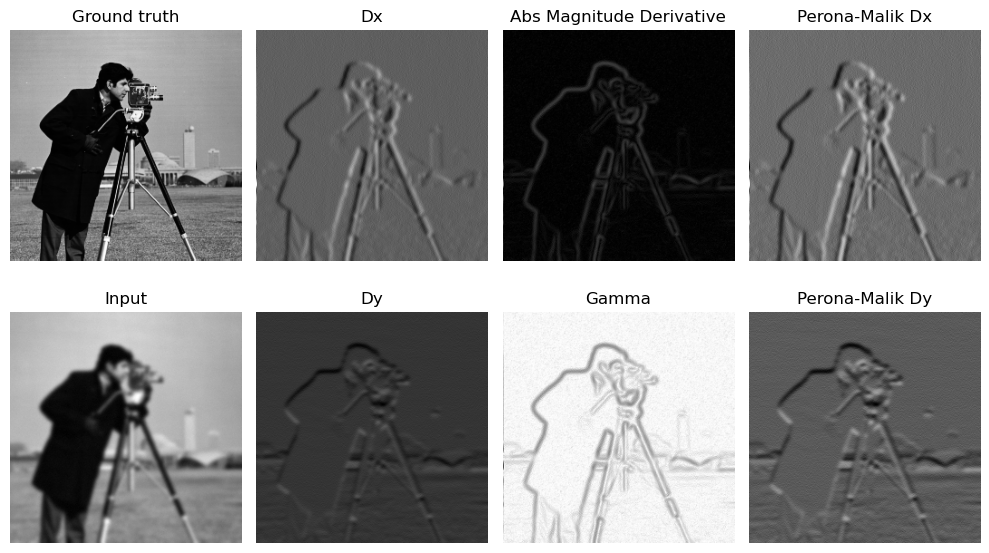

In [4]:
"""Visualise Perona-Malik regularisation"""

Dx = dx_operator(g, conv_mode="periodic")
Dy = dy_operator(g, conv_mode="periodic")
flat_dims = np.prod(g.shape)
dx_g = Dx @ g.flatten()
dy_g = Dy @ g.flatten()
abs_derivative = np.sqrt(np.square(dx_g) + np.square(dy_g))
threshold = 0.5 * np.max(abs_derivative)
gamma = np.exp(-abs_derivative / threshold)
gamma_diag_hat = np.sqrt(sp.diags(gamma.ravel()))
pm = sp.vstack([gamma_diag_hat @ Dx, gamma_diag_hat @ Dy])
pm_g = pm @ g.flatten()

fig, axs = plt.subplots(2, 4, figsize=(10, 6))

axs[0, 0].imshow(f, cmap="gray")
axs[0, 0].set_title("Ground truth")
axs[0, 0].axis("off")
axs[0, 1].imshow(dx_g.reshape(g.shape), cmap="gray")
axs[0, 1].set_title("Dx")
axs[0, 1].axis("off")
axs[0, 2].imshow(abs_derivative.reshape(g.shape), cmap="gray")
axs[0, 2].set_title("Abs Magnitude Derivative")
axs[0, 2].axis("off")
axs[0, 3].imshow(pm_g[0:flat_dims].reshape(g.shape), cmap="gray")
axs[0, 3].set_title("Perona-Malik Dx")
axs[0, 3].axis("off")
axs[1, 0].imshow(g, cmap="gray")
axs[1, 0].set_title("Input")
axs[1, 0].axis("off")
axs[1, 1].imshow(dy_g.reshape(g.shape), cmap='gray')
axs[1, 1].set_title("Dy")
axs[1, 1].axis("off")
axs[1, 2].imshow(gamma.reshape(g.shape), cmap="gray")
axs[1, 2].set_title("Gamma")
axs[1, 2].axis("off")
axs[1, 3].imshow(pm_g[flat_dims:].reshape(g.shape), cmap="gray")
axs[1, 3].set_title("Perona-Malik Dy")
axs[1, 3].axis("off")

plt.tight_layout()
plt.show()

In [5]:
"""Set up parameters"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

[INFO] 2025-02-25 19:29:39 | Alpha 1e-08: discrepancy -5.419464524374607e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:40 | Alpha 1e-07: discrepancy -5.419454499450438e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:42 | Alpha 1e-06: discrepancy -5.419299330120108e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:42 | Alpha 1e-05: discrepancy -5.414039138947779e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:43 | Alpha 0.0001: discrepancy -5.210903169195098e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:44 | Alpha 0.001: discrepancy -3.586117218159701e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:44 | Alpha 0.01: discrepancy 2.9380052705036827e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:45 | Alpha 0.1: discrepancy 0.0023020670680829595 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:45 | Alpha 1.0: discrepancy

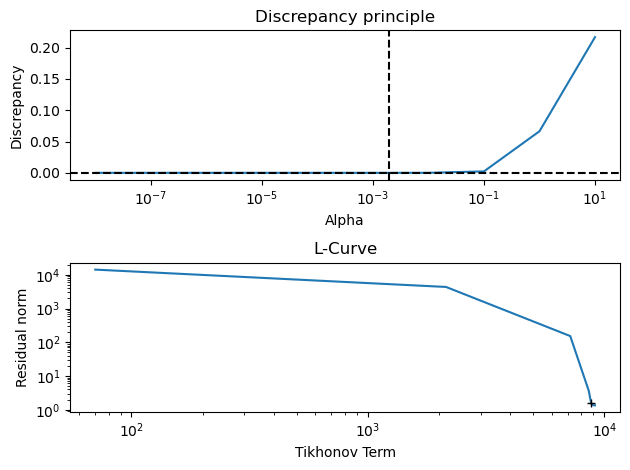

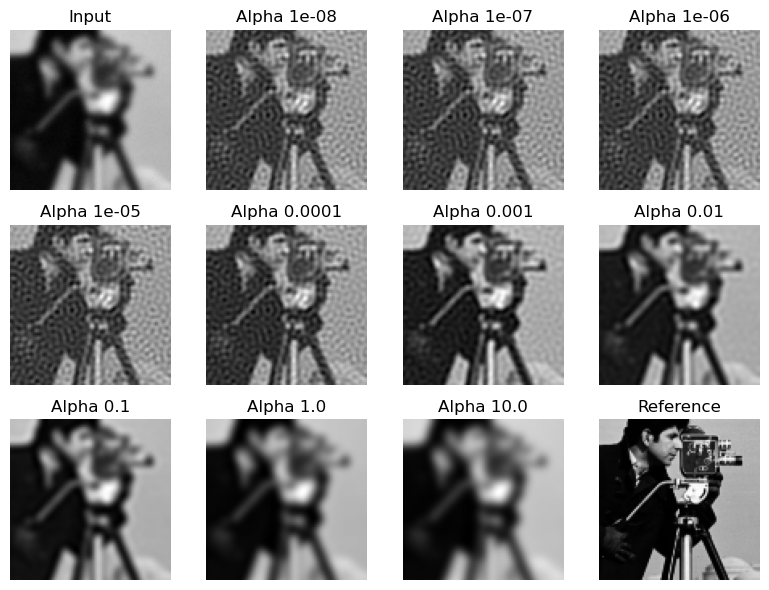

Optimal alpha: 0.0019790356307278234
DP: -1.973651943956634e-06, MSE: 0.003255488143392356


In [6]:
"""Optimise for TK0"""

lsqr_tk0 = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk0.parameter_sweep(alphas=alphas, L=identity_operator, save_imgs=True)
lsqr_tk0.display_metrics()
lsqr_tk0.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tk0.optimal_alpha}")
print(f"DP: {lsqr_tk0.optimal_metrics['discrepancy']}, MSE: {lsqr_tk0.optimal_metrics['MSE']}")

[INFO] 2025-02-25 19:29:48 | Alpha 1e-08: discrepancy -5.419456795989892e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:49 | Alpha 1e-07: discrepancy -5.419376149234241e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:50 | Alpha 1e-06: discrepancy -5.418411665139614e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:51 | Alpha 1e-05: discrepancy -5.396380496256007e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:51 | Alpha 0.0001: discrepancy -4.96935964083634e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:52 | Alpha 0.001: discrepancy -3.489337669826799e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:52 | Alpha 0.01: discrepancy 1.8928118215122748e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:53 | Alpha 0.1: discrepancy 4.5089704449328495e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:53 | Alpha 1.0: discrepancy

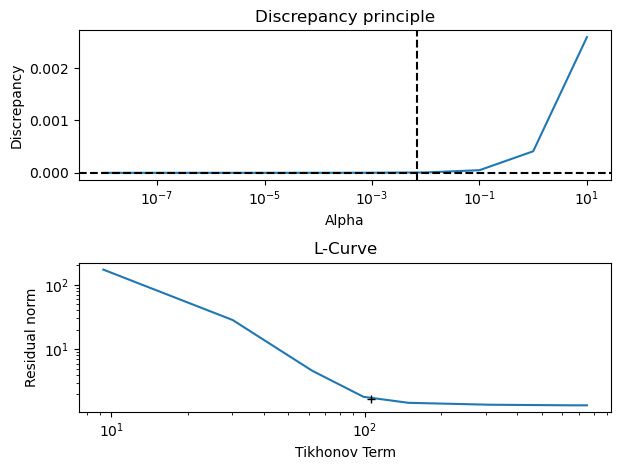

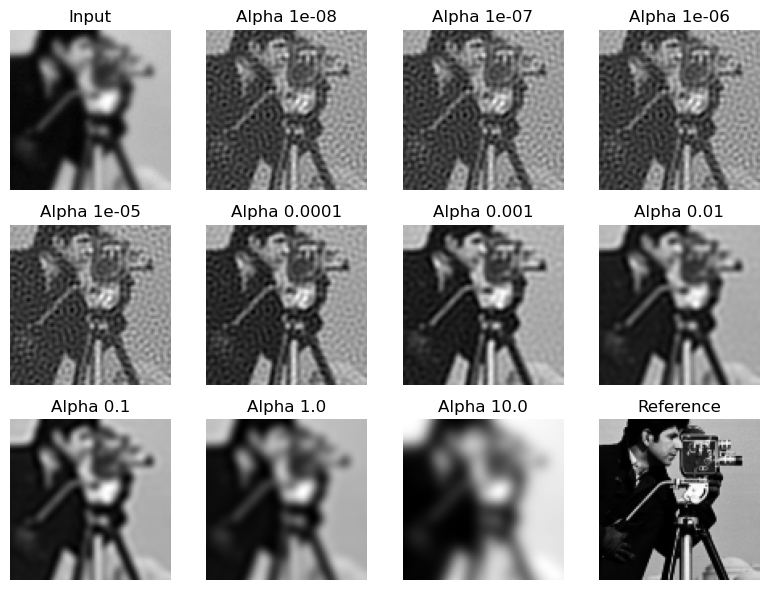

Optimal alpha: 0.006834850755999327
DP: 2.0333891590431106e-07, MSE: 0.0036184793983491765


In [7]:
"""Optimise for TK1"""

lsqr_tk1 = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_tk1.parameter_sweep(alphas=alphas, L=derivative_operator, save_imgs=True)
lsqr_tk1.display_metrics()
lsqr_tk1.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tk1.optimal_alpha}")
print(f"DP: {lsqr_tk1.optimal_metrics['discrepancy']}, MSE: {lsqr_tk1.optimal_metrics['MSE']}")

[INFO] 2025-02-25 19:29:57 | Alpha 1e-08: discrepancy -5.419457330709564e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:58 | Alpha 1e-07: discrepancy -5.419381731558625e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:29:59 | Alpha 1e-06: discrepancy -5.4184901557182e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:00 | Alpha 1e-05: discrepancy -5.398772218508947e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:01 | Alpha 0.0001: discrepancy -5.004031740067502e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:02 | Alpha 0.001: discrepancy -3.6215017263580998e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:02 | Alpha 0.01: discrepancy 7.741109391351127e-07 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:02 | Alpha 0.1: discrepancy 3.305782881134291e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:30:02 | Alpha 1.0: discrepancy 0

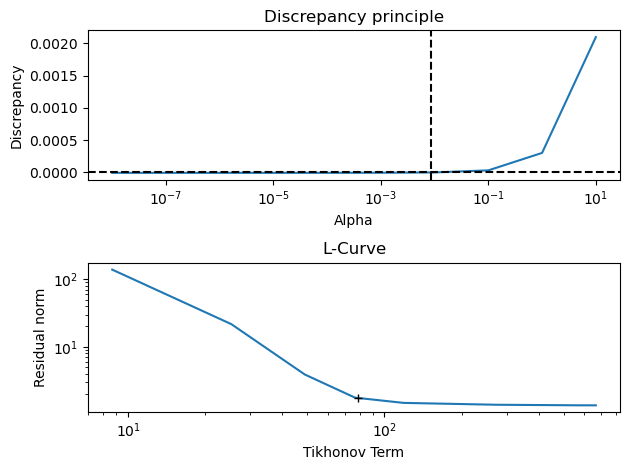

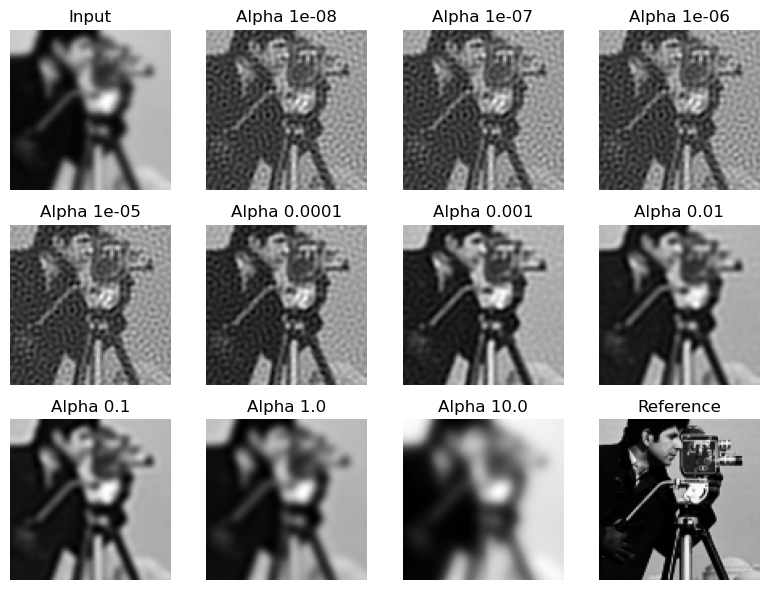

Optimal alpha: 0.008415010834119007
DP: 1.1819969263233141e-07, MSE: 0.003525873821232266


In [8]:
"""Optimise and generate example images Perona-Malik"""

lsqr_pm = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm.parameter_sweep(alphas=alphas, L=perona_malik_operator, save_imgs=True)
lsqr_pm.display_metrics()
lsqr_pm.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_pm.optimal_alpha}")
print(f"DP: {lsqr_pm.optimal_metrics['discrepancy']}, MSE: {lsqr_pm.optimal_metrics['MSE']}")

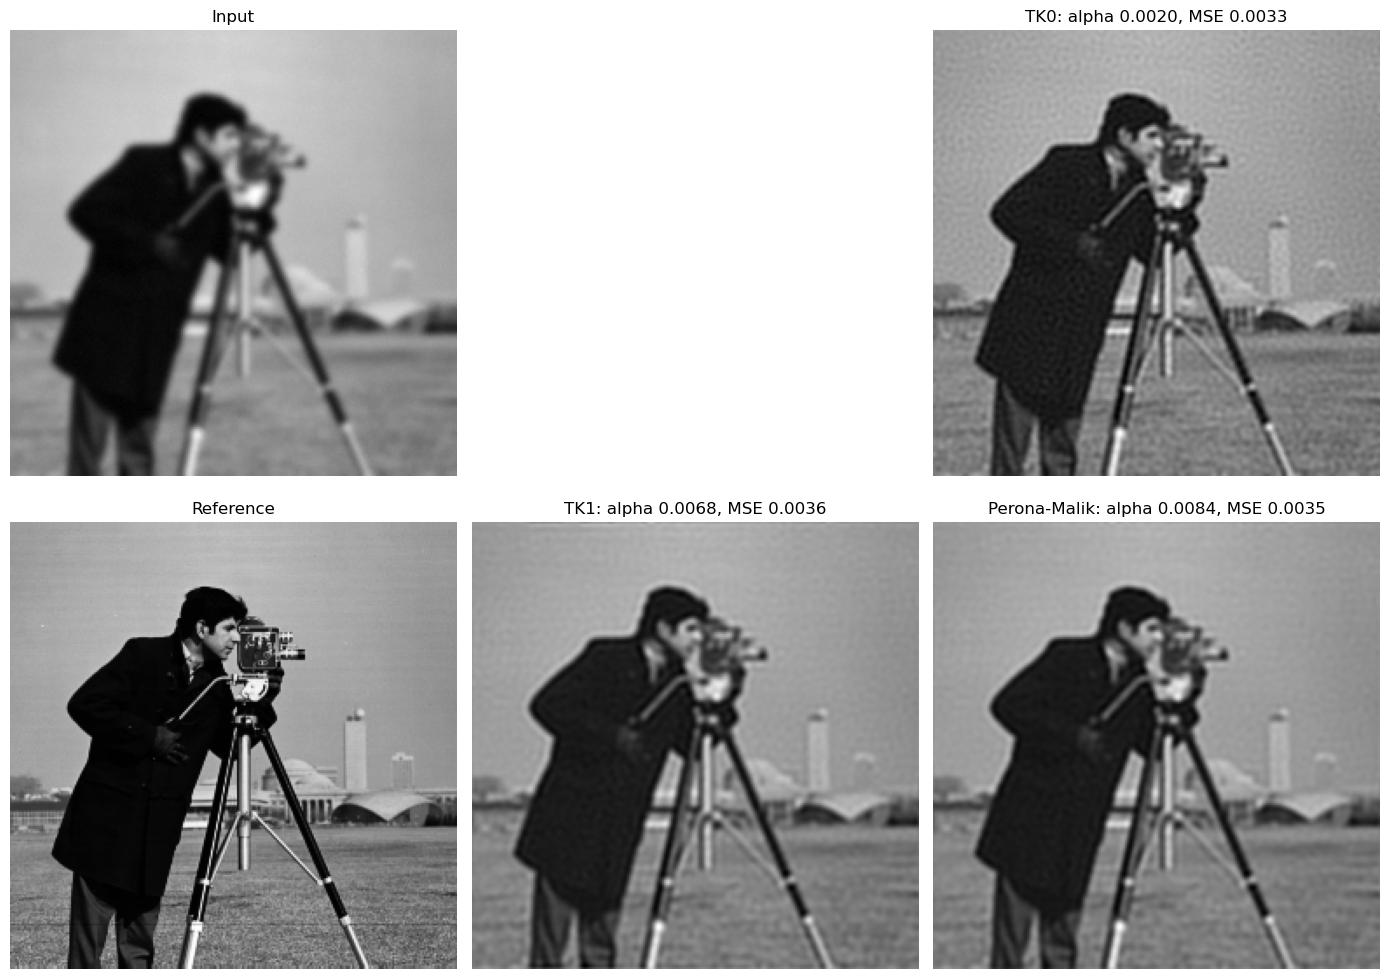

In [9]:
"""Compare regularisation techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 2].imshow(lsqr_tk0._optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_tk1._optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm._optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

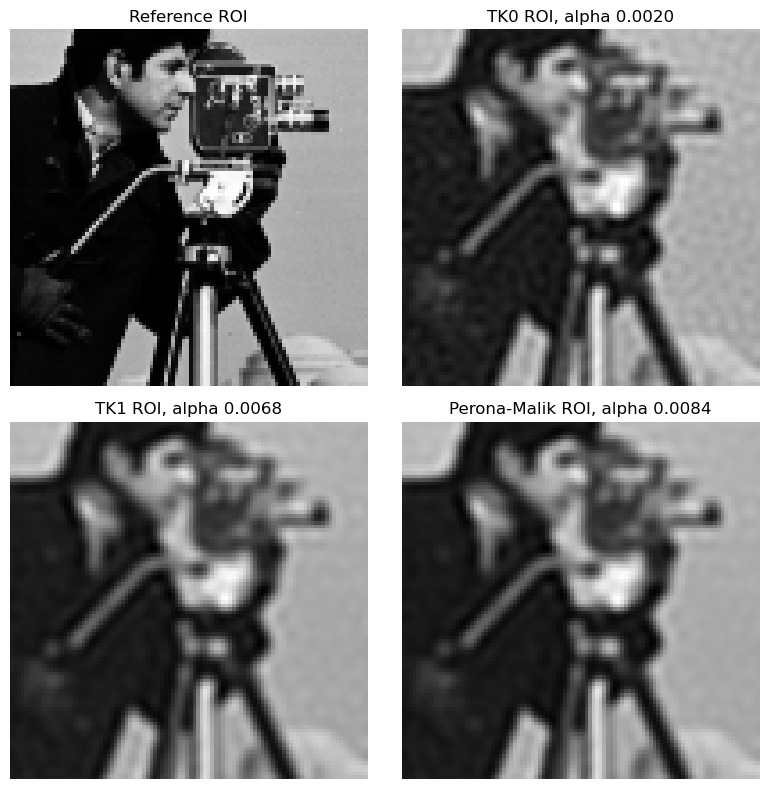

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Reference ROI")
axs[0, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0 ROI, alpha {lsqr_tk0.optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[1, 0].imshow(lsqr_tk1.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 0].set_title(f"TK1 ROI, alpha {lsqr_tk1.optimal_alpha:.4f}")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik ROI, alpha {lsqr_pm.optimal_alpha:.4f}")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

[WARNING] 2025-02-25 19:32:49 | Alpha 1e-08: Maximum iterations reached | evaluation.tuning-parameter_sweep:313
[WARNING] 2025-02-25 19:35:31 | Alpha 1e-07: Maximum iterations reached | evaluation.tuning-parameter_sweep:313
[INFO] 2025-02-25 19:37:27 | Alpha 1e-06: discrepancy -7.54833073116094e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:38:17 | Alpha 1e-05: discrepancy -6.380694298631876e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:38:35 | Alpha 0.0001: discrepancy -5.167550037694766e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:38:59 | Alpha 0.001: discrepancy -3.7581805633039906e-06 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:39:30 | Alpha 0.01: discrepancy -4.60213499261326e-08 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:39:47 | Alpha 0.1: discrepancy 2.8170690099774115e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 19:40:03 | Alpha 1.0: discrepancy 0.00028638883

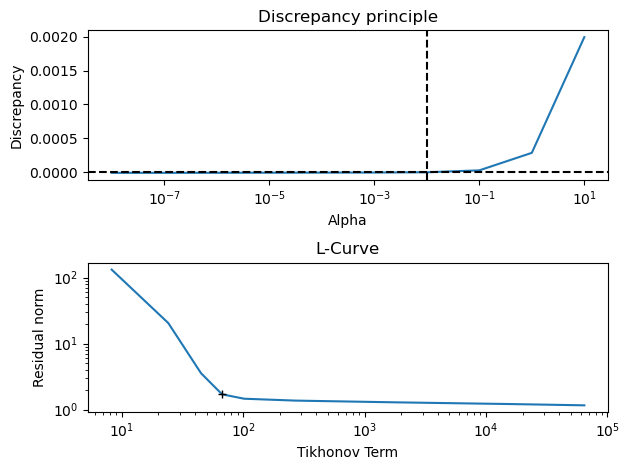

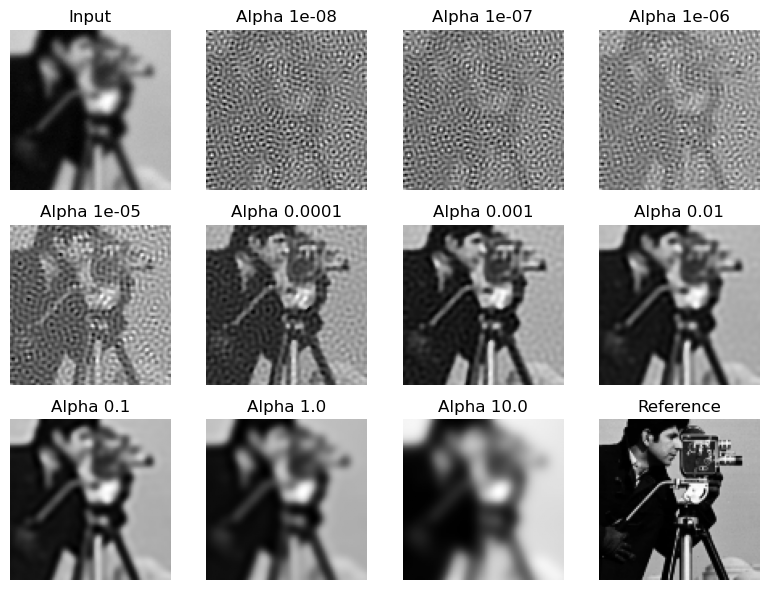

Optimal alpha: 0.010146789660472498
DP: 2.613552863972563e-09, MSE: 0.003406104017766148


In [11]:
"""Generate example images using iterative Perona-Malik"""

lsqr_pm_iter = IterativeTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)
lsqr_pm_iter.parameter_sweep(alphas=alphas, L=perona_malik_operator, save_imgs=True)
lsqr_pm_iter.display_metrics()
lsqr_pm_iter.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_pm_iter.optimal_alpha}")
print(f"DP: {lsqr_pm_iter.optimal_metrics['discrepancy']}, MSE: {lsqr_pm_iter.optimal_metrics['MSE']}")

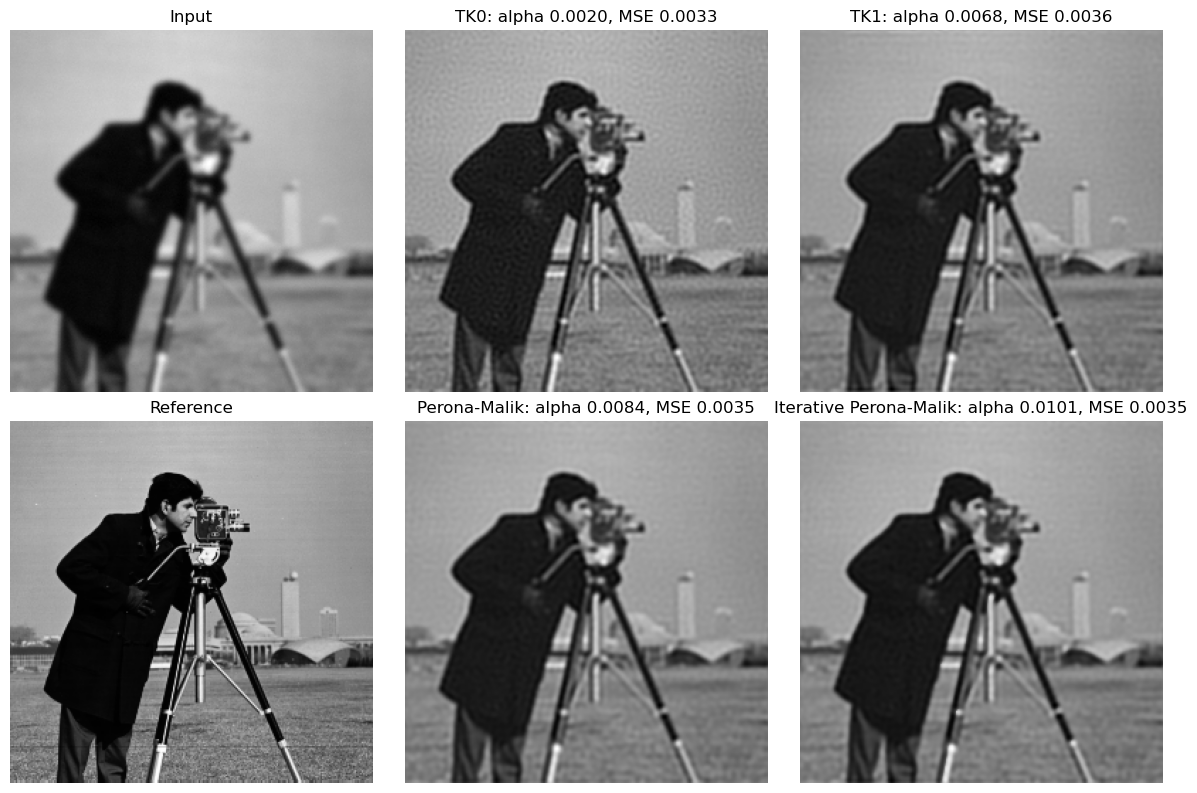

In [12]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat, cmap="gray")
axs[0, 1].set_title(f"TK0: alpha {lsqr_tk0.optimal_alpha:.4f}, MSE {lsqr_tk0.optimal_metrics['MSE']:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1.optimal_f_hat, cmap="gray")
axs[0, 2].set_title(f"TK1: alpha {lsqr_tk1.optimal_alpha:.4f}, MSE {lsqr_tk1.optimal_metrics['MSE']:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat, cmap="gray")
axs[1, 1].set_title(f"Perona-Malik: alpha {lsqr_pm.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter.optimal_f_hat, cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik: alpha {lsqr_pm_iter.optimal_alpha:.4f}, MSE {lsqr_pm.optimal_metrics['MSE']:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

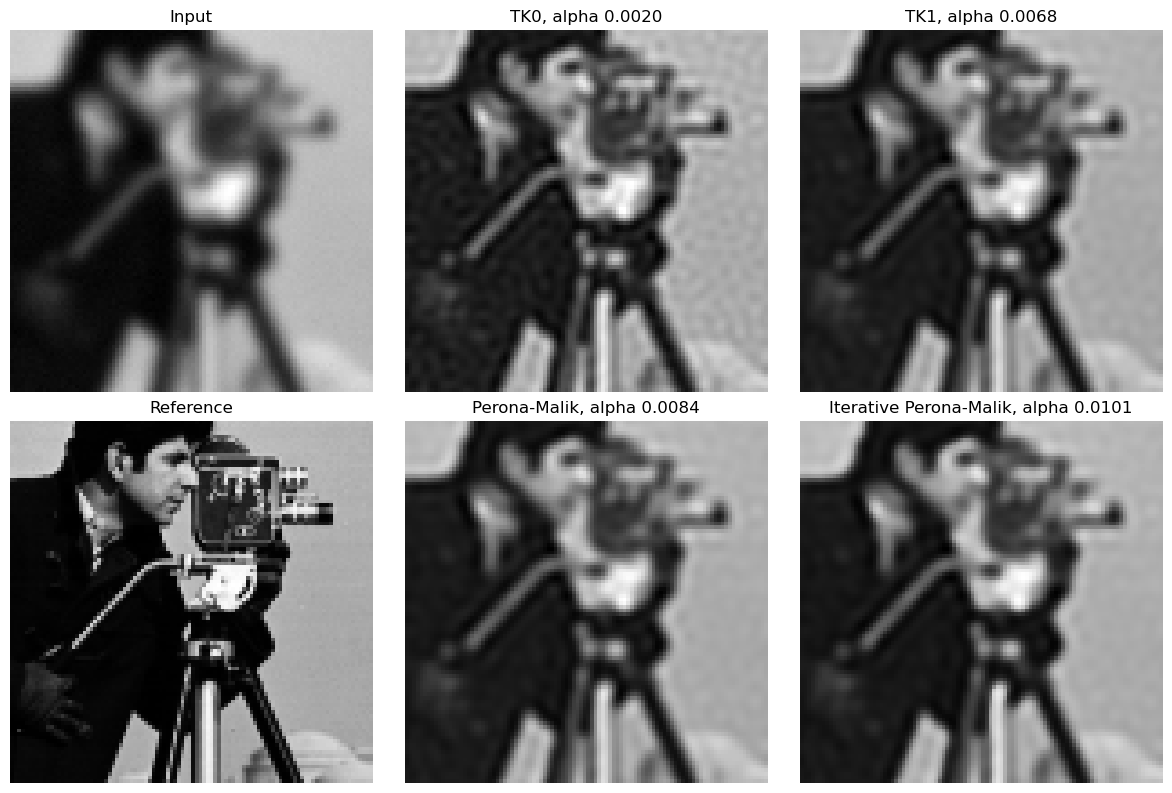

In [13]:
"""Compare regularisation techniques"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(g[50:150, 80:180], cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[1, 0].imshow(f[50:150, 80:180], cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[0, 1].imshow(lsqr_tk0.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 1].set_title(f"TK0, alpha {lsqr_tk0.optimal_alpha:.4f}")
axs[0, 1].axis("off")
axs[0, 2].imshow(lsqr_tk1.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[0, 2].set_title(f"TK1, alpha {lsqr_tk1.optimal_alpha:.4f}")
axs[0, 2].axis("off")
axs[1, 1].imshow(lsqr_pm.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 1].set_title(f"Perona-Malik, alpha {lsqr_pm.optimal_alpha:.4f}")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_pm_iter.optimal_f_hat[50:150, 80:180], cmap="gray")
axs[1, 2].set_title(f"Iterative Perona-Malik, alpha {lsqr_pm_iter.optimal_alpha:.4f}")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [14]:
print(f"TK0: optimal alpha {lsqr_tk0.optimal_alpha:.4f}")
print(lsqr_tk0.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"TK1: optimal alpha {lsqr_tk1.optimal_alpha:.4f}")
print(lsqr_tk1.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Perona-Malik: optimal alpha {lsqr_pm.optimal_alpha:.4f}")
print(lsqr_pm.optimal_metrics[["MSE", "pSNR", "SSIM"]])
print(f"Iterative Perona-Malik: optimal alpha {lsqr_pm_iter.optimal_alpha:.4f}")
print(lsqr_pm_iter.optimal_metrics[["MSE", "pSNR", "SSIM"]])

TK0: optimal alpha 0.0020
MSE      0.003255
pSNR    24.873839
SSIM     0.734293
Name: optimal, dtype: object
TK1: optimal alpha 0.0068
MSE      0.003618
pSNR    24.414739
SSIM     0.784532
Name: optimal, dtype: object
Perona-Malik: optimal alpha 0.0084
MSE      0.003526
pSNR    24.527332
SSIM     0.791895
Name: optimal, dtype: object
Iterative Perona-Malik: optimal alpha 0.0101
MSE      0.003406
pSNR    24.677421
SSIM     0.798128
Name: optimal, dtype: object
